In [1]:
%pip install riskfolio-lib==6.1.1

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import riskfolio as rp
import statsmodels

In [4]:
data_inicial = 13 #  13 = 01/2005
data_final   = data_inicial + 204 # 12/2021
colunas = 291 #len(comp_indice.columns)
step_port = 1
step_eval = 1

#Composição do índice IBX
comp_indice=pd.read_excel('Dados-Comp-IBRX.xlsx', engine='openpyxl')
comp_indice.set_index(keys = 'Data', inplace = True)

#Preços de fechamento dos ativos
fechamento=pd.read_excel('Dados-Fechamento.xlsx', engine='openpyxl')
fechamento.set_index(keys = 'Data', inplace = True)

#Indices de referência (Ibov, IBX, SELIC...)
referencias=pd.read_excel('Dados-Base.xlsx', engine='openpyxl')
referencias.set_index(keys = 'Data', inplace = True)
#-------------------------------------------

# Fator Qualidade (ROIC das empresas)
fator_ROIC=pd.read_excel('Dados-ROIC-A2.xlsx', engine='openpyxl')
fator_ROIC.set_index(keys = 'Data', inplace = True)
ranked_ROIC=fator_ROIC.rank(axis=1, numeric_only=True, ascending=False, method='first')

# Fator Momentum (Momentum de 12 meses)
fator_Mom=pd.read_excel('Dados-Momentum-12.xlsx', engine='openpyxl')
fator_Mom.set_index(keys = 'Data', inplace = True)
ranked_Mom=fator_Mom.rank(axis=1, numeric_only=True, ascending=False, method='first')

#Fator Tamanho (Valor de mercado das empresas)
fator_Val_Merc=pd.read_excel('Dados-Val-Merc.xlsx', engine='openpyxl')
fator_Val_Merc.set_index(keys = 'Data', inplace = True)
ranked_Val_Merc=fator_Val_Merc.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Valor (Preço / Valor Patrimonial)
fator_PVP=pd.read_excel('Dados-PVP.xlsx', engine='openpyxl')
fator_PVP.set_index(keys = 'Data', inplace = True)
ranked_PVP=fator_PVP.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Volatilidade (Volatilidade em 12 meses)
fator_Vol=pd.read_excel('Dados-Vol-12.xlsx', engine='openpyxl')
fator_Vol.set_index(keys = 'Data', inplace = True)
ranked_Vol=fator_Vol.rank(axis=1, numeric_only=True, ascending=True, method='first')

print("Periodo de avaliacao - de:", comp_indice.index[data_inicial], "(", data_inicial, ")",  "ate:", comp_indice.index[data_final-1], "(", data_final-1, ")")
print("Rebalanceamento a cada", step_eval,"/", step_port, "meses")

Periodo de avaliacao - de: Jan-2005 ( 13 ) ate: Dez-2021 ( 216 )
Rebalanceamento a cada 1 / 1 meses


In [5]:
#Funções de apoio

#Seleção das ações que compõe um portfólio.
#Parâmetros: (fator, ranking_inicio, ranking_fim)
#Retorno: portfólio
def SelPort1(port_ranked_1, param_1a, param_1b):

    port_ranked_final = port_ranked_1.copy()
    port_ranked_final.loc[:, :] = 0

    for lin in range(data_inicial, data_final, step_port):
        for col in range(0, colunas):
            if ((port_ranked_1.iat[lin-1, col]  >= param_1a) and (port_ranked_1.iat[lin-1, col]  <= param_1b)):
                port_ranked_final.iat[lin-1, col] = 1

    return port_ranked_final
#--------------------------
#Seleção das ações que compõe um portfólio com 2 fatores.
#Parâmetros: (fator1, limite1, fator2, limite2)
#Retorno: portfólio

def SelPort2Par(ranked_1, param_1, ranked_2, param_2):
  port_ranked_final = ranked_1.copy()
  port_ranked_final.loc[:, :] = 0

  for lin in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranked_1.iat[lin-1, col]  >= 1) and (ranked_1.iat[lin-1, col]  <= param_1) and
          (ranked_2.iat[lin-1, col]  >= 1) and (ranked_2.iat[lin-1, col]  <= param_2)):
        port_ranked_final.iat[lin-1, col] = 1

  return port_ranked_final
#--------------------------

#Avaliação de um portfólio.
#Parâmetros: (portfólio, histórico de preços dos ativos)
#Retorno: vetor com retorno acumulado, vetor com retornos periódicos, vetor com drawdown, retorno anualizado, volatilidade anualizada
def EvalPort(port, fechamento):
    port_acc_vet = []
    port_chg_vet = []
    port_ddown_vet = []

    port_acc = 1.0
    port_acc_vet.append(1.0)
    cost_trans = 0.0006
    #cost_trans = 0.0005 + (0.004*step_eval/12)

    for lin in range(data_inicial, data_final, step_eval):
        cont = 0.0
        rent = 0.0
        for col in range(0, colunas):
            if (port.iat[lin-1, col] > 0 and fechamento.iat[lin-1, col]>0 and fechamento.iat[lin-1+step_eval, col]>0):
                rent = rent + (fechamento.iat[lin-1+step_eval,col]/fechamento.iat[lin-1,col]-1)*(port.iat[lin-1, col])
                cont = cont + port.iat[lin-1, col]
        if (cont == 0):
          return [1,1], [1,1], [0,0], 0, 0.000001
        port_acc = port_acc * (1.0 + rent/cont - cost_trans)
        port_chg_vet.append(rent/cont - cost_trans)
        port_acc_vet.append(port_acc)
        port_ddown_vet.append(port_acc/(np.max(port_acc_vet))-1)

    ret_aa = pow(port_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(port_chg_vet)*((12/step_eval)**(1/2))
    return port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa
#--------------------------

#Avaliação de um índice de referência.
#Parâmetros: (dataframe de referências, indice da referência desejada [0 - Ibovespa, 1 - IBX])
##Retorno: vetor com retorno acumulado, vetor com retornos periódicos, vetor com drawdown, retorno anualizado, volatilidade anualizada
def EvalRef(ref, ind):
    ref_acc_vet = []
    ref_chg_vet = []
    ref_ddown_vet = []

    ref_acc = 1.0
    ref_acc_vet.append(1.0)

    for lin in range(data_inicial, data_final, step_eval):
        rent = ref.iat[lin-1+step_eval,ind]/ref.iat[lin-1,ind]
        ref_acc = ref_acc * rent
        ref_chg_vet.append(rent-1)
        ref_acc_vet.append(ref_acc)
        ref_ddown_vet.append(ref_acc/(np.max(ref_acc_vet))-1)

    ret_aa = pow(ref_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(ref_chg_vet)*((12/step_eval)**(1/2))
    return ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa, vol_aa


In [6]:
#-------------------------- Riskfolio ----------

def calc_riskfolio_opt (ranked, otim_opt):
  hist_size = 24
  port = ranked.copy()
  #rm = rm_par

  if (otim_opt == 'RP'):
    print("\nCalc. Risk Parity Portfolio")
  elif (otim_opt == 'GMV'):
    print("\nCalc. Global Minimun Variance Portfolio")
  elif (otim_opt == 'MDP'):
    print("\nCalc. Maximun Decorrelation Portfolio")
  else:
    print("\nOpcao Invalida.")

#  print("\nCalc HRP")

  for lin in range(data_inicial+hist_size, data_final, 1):
    print("\r",lin, "/", data_final-1, end=' ')
    port_comp = pd.DataFrame()
    for col in range(0, colunas):
      if (port.iat[lin-1, col] > 0):
        port_comp[port.columns[col]]=fechamento[port.columns[col]].iloc[lin-1-hist_size:lin-1]

    port_comp.fillna(method='backfill', axis=0, inplace=True)

    port_comp_chg = port_comp.pct_change().dropna()


#---------
    # Hierarchical Risk Parity
    #hrp_port = rp.HCPortfolio(returns=port_comp_chg)
    #w = hrp_port.optimization(model=model, codependence=codependence, rm='MV', rf=0, linkage='average', max_k=10, leaf_order=True)

    # Standard Risk Parity
    if (otim_opt == 'RP'):
      rp_port = rp.Portfolio(returns=port_comp_chg)
      rp_port.assets_stats(d=0.94, method_cov='hist')
      w = rp_port.rp_optimization(rm='MV', b = None)

    # Minimun Variance
    elif (otim_opt == 'GMV'):
      gmv_port = rp.Portfolio(returns=port_comp_chg)
      gmv_port.assets_stats(d=0.94)
      w = gmv_port.optimization(model='Classic', rm='MV', obj='MinRisk')

    # Maximun Decorrelation
    elif (otim_opt == 'MDP'):
      mdp_port = rp.Portfolio(returns=port_comp_chg)
      mdp_port.assets_stats(d=0.94)
      mdp_port.cov = port_comp_chg.corr()
      w = mdp_port.optimization(model='Classic', rm='MV', obj='MinRisk')


#-----------

    port_len = len(port_comp_chg.columns)
    for at in range(port_len):
      port.at[port.index[lin-1], port_comp.columns[at]] = w['weights'].iat[at]
      #if ((lin-1)==40):
      #  print(port_comp.columns[at], w['weights'].iat[at])

    #if ((lin-1)==40):
    #  display(w)

  port_final = port.copy()
  return port_final

**Modelo 1: Maior retorno**

In [7]:
# Cálculo de rentabilidade / volatilidade / drawdown da SELIC
#ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 2)
#print("Ref SELIC:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do IBX
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 1)
print("Ref IBX:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do Ibovespa
#ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 0)
#print("Ref Ibov:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

Ref IBX:
Ret. Acc.: 474.01 % Ret. Anual.: 10.83 % Vol.: 22.38 % Ret/Vol: 0.48 DDown: -49.74 %


In [8]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)
ranked1 = SelPort1(ranked_Mom, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port Fator Mom:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port Fator Mom:
Ret. Acc.: 1111.46 % Ret. Anual.: 15.8 % Vol.: 21.96 % Ret/Vol: 0.72 DDown: -46.05 %


In [9]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)
ranked2 = SelPort1(ranked_ROIC, 0, 30) # É retornando um portfolio rankeado pelo fator selecionado que é refeito a cada 1
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port Fator Qual:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

Port Fator Qual:
Ret. Acc.: 696.9 % Ret. Anual.: 12.99 % Vol.: 21.04 % Ret/Vol: 0.62 DDown: -48.83 %


In [10]:
ranked3 = SelPort2Par(ranked_Mom, 30, ranked_ROIC, 30)
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(ranked3, fechamento)
print("\nPort Fator Mom & Qual:\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet3, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Port Fator Mom & Qual:
Ret. Acc.: 1367.31 % Ret. Anual.: 17.12 % Vol.: 21.6 % Ret/Vol: 0.79 DDown: -48.12 %
Port Alpha: 8.32 %, Beta: 0.77


In [11]:
port_riskfolio = calc_riskfolio_opt(ranked3, 'RP')
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3, 'GMV')
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRet. Acc.:",round(port_acc_vet5[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa5*100,2), "% Vol.:", round(vol_aa5*100,2), "% Ret/Vol:", round(ret_aa5/vol_aa5, 2), "DDown:", round(np.min(port_ddown_vet5)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3, 'MDP')
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRet. Acc.:",round(port_acc_vet6[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa6*100,2), "% Vol.:", round(vol_aa6*100,2), "% Ret/Vol:", round(ret_aa6/vol_aa6, 2), "DDown:", round(np.min(port_ddown_vet6)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Calc. Risk Parity Portfolio
 216 / 216 
Port RP:
Ret. Acc.: 1073.73 % Ret. Anual.: 15.59 % Vol.: 20.16 % Ret/Vol: 0.77 DDown: -42.68 %
Port Alpha: 7.53 %, Beta: 0.71

Calc. Global Minimun Variance Portfolio
 216 / 216 
Port GMV:
Ret. Acc.: 772.96 % Ret. Anual.: 13.59 % Vol.: 19.1 % Ret/Vol: 0.71 DDown: -31.44 %
Port Alpha: 7.01 %, Beta: 0.59

Calc. Maximun Decorrelation Portfolio
 216 / 216 
Port MDP:
Ret. Acc.: 1800.66 % Ret. Anual.: 18.91 % Vol.: 22.8 % Ret/Vol: 0.83 DDown: -43.41 %
Port Alpha: 11.02 %, Beta: 0.7


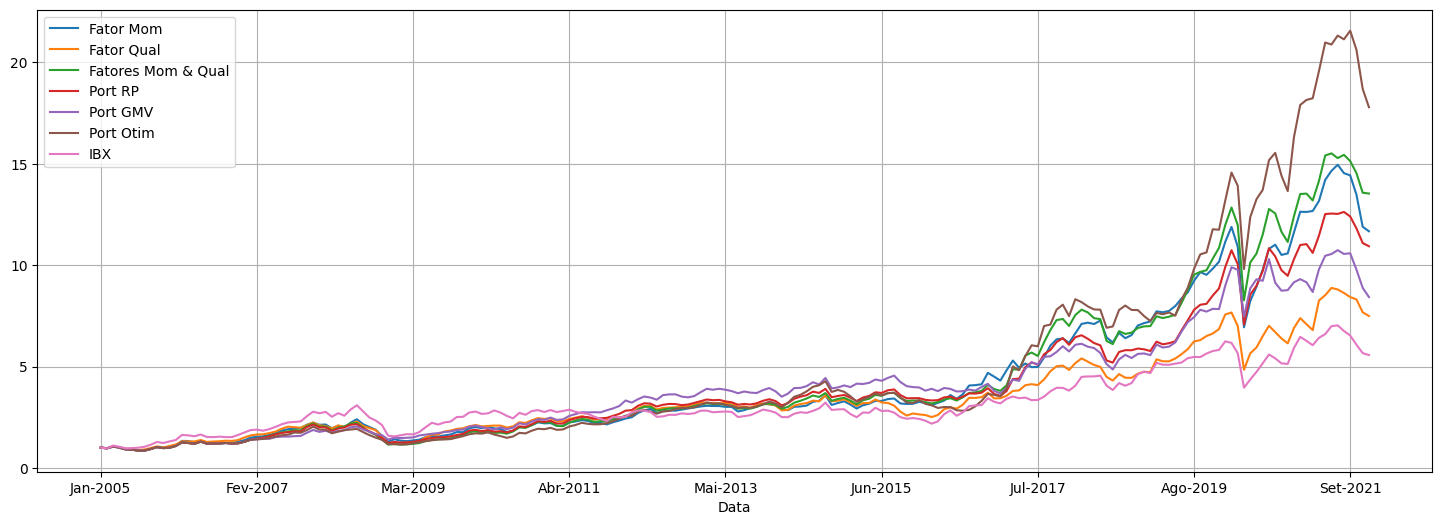

In [12]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
# Definindo o comprimento do índice de final_df
index_length = len(ranked_ROIC.iloc[data_inicial:data_final+1].index)

# Ajustando os vetores para ter o mesmo comprimento do índice
port_acc_vet1 = port_acc_vet1[:index_length]
port_acc_vet2 = port_acc_vet2[:index_length]
port_acc_vet3 = port_acc_vet3[:index_length]
port_acc_vet4 = port_acc_vet4[:index_length]
port_acc_vet5 = port_acc_vet5[:index_length]
port_acc_vet6 = port_acc_vet6[:index_length]
ref_acc_vet = ref_acc_vet[:index_length]

final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Fator Mom'] = port_acc_vet1
final_df['Fator Qual'] = port_acc_vet2
final_df['Fatores Mom & Qual'] = port_acc_vet3
final_df['Port RP'] = port_acc_vet4
final_df['Port GMV'] = port_acc_vet5
final_df['Port Otim'] = port_acc_vet6
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

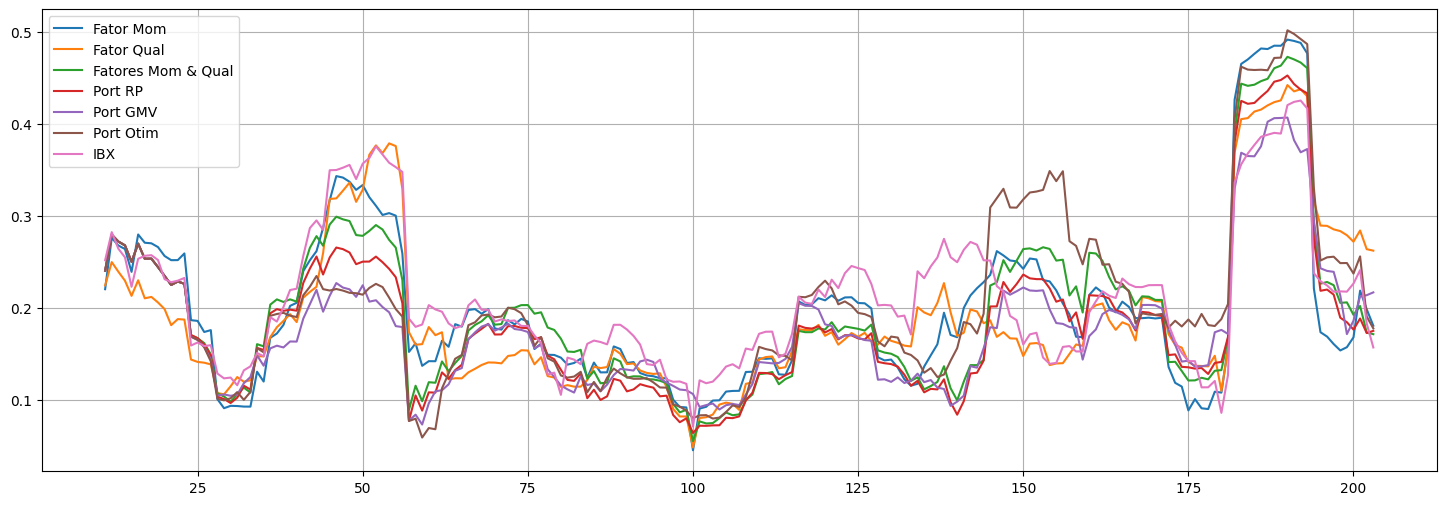

In [13]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Fator Mom'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Fator Qual'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Fatores Mom & Qual'] = pd.Series(port_chg_vet3).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port RP'] = pd.Series(port_chg_vet4).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port GMV'] = pd.Series(port_chg_vet5).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port Otim'] = pd.Series(port_chg_vet6).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

<Axes: xlabel='Data'>

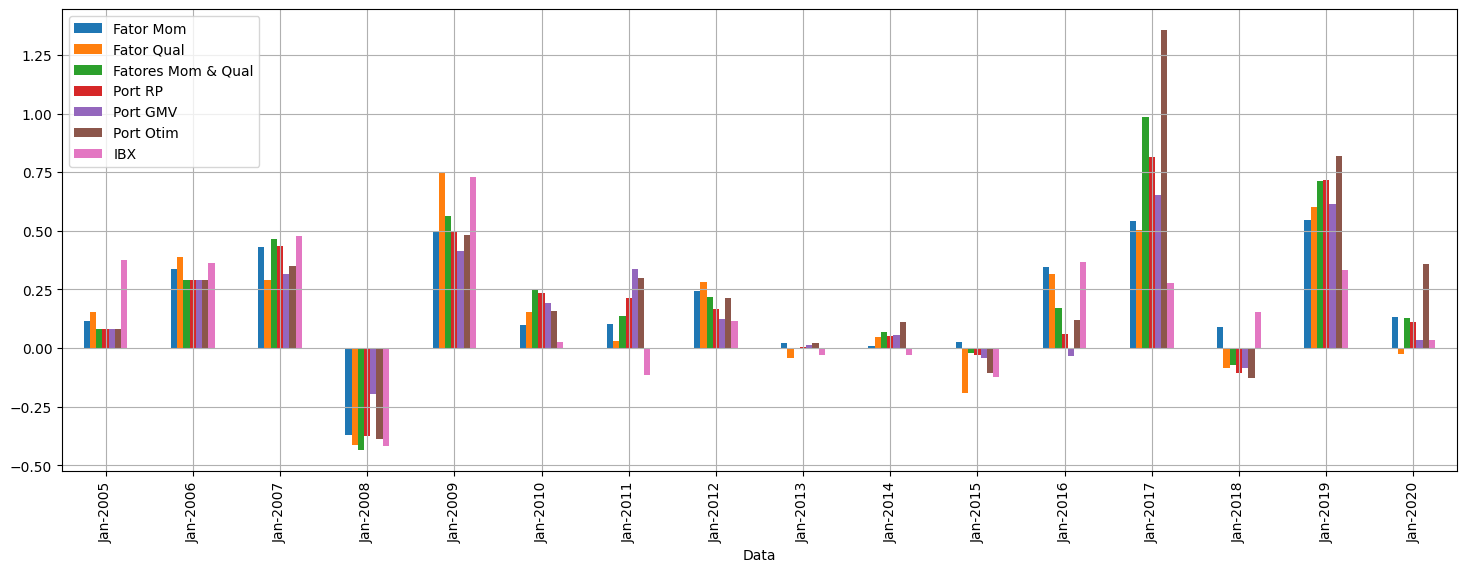

In [14]:
#Retorno anual de um portfólio e de uma referência (IBX)
final_df12 = pd.DataFrame(columns=['Data', 'Fator Mom', 'Fator Qual', 'Fatores Mom & Qual', 'Port RP', 'Port GMV', 'Port Otim', 'IBX'])

for ind in range(0, len(final_df.index) - 12, 12):
    final_temp = final_df.iloc[ind + 12] / final_df.iloc[ind] - 1
    final_temp = final_temp.to_frame().T  # Transpor para garantir que é um DataFrame de uma linha
    final_temp['Data'] = final_df.index[ind]  # Adicionar a coluna de Data
    final_df12 = pd.concat([final_df12, final_temp], ignore_index=True)

# Configurar a coluna 'Data' como índice
final_df12.set_index(keys='Data', inplace=True)

# Plotar os dados
final_df12.plot.bar(figsize=(18, 6), grid=True)

**Modelo 2 Maior relação retorno/volatilidade**

In [15]:
# Cálculo de rentabilidade / volatilidade / drawdown da SELIC
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 2)
print("Ref SELIC:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do IBX
#ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 1)
#print("Ref IBX:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do Ibovespa
#ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 0)
#print("Ref Ibov:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

Ref SELIC:
Ret. Acc.: 419.54 % Ret. Anual.: 10.18 % Vol.: 1.1 % Ret/Vol: 9.23 DDown: 0.0 %


In [16]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)
ranked1 = SelPort1(ranked_Mom, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port Fator Mom:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port Fator Mom:
Ret. Acc.: 1111.46 % Ret. Anual.: 15.8 % Vol.: 21.96 % Ret/Vol: 0.72 DDown: -46.05 %


In [18]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)
ranked2 = SelPort1(ranked_Vol, 0, 30)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port Fator Vol:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

Port Fator Vol:
Ret. Acc.: 607.62 % Ret. Anual.: 12.2 % Vol.: 17.26 % Ret/Vol: 0.71 DDown: -33.37 %


In [19]:
ranked3 = SelPort2Par(ranked_Mom, 30, ranked_Vol, 30)
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(ranked3, fechamento)
print("\nPort Fator Mom & Vol:\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet3, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Port Fator Mom & Vol:
Ret. Acc.: 2984.78 % Ret. Anual.: 22.35 % Vol.: 18.71 % Ret/Vol: 1.19 DDown: -30.97 %
Port Alpha: 34.06 %, Beta: -1.23


In [20]:
port_riskfolio = calc_riskfolio_opt(ranked3, 'RP')
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3, 'GMV')
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRet. Acc.:",round(port_acc_vet5[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa5*100,2), "% Vol.:", round(vol_aa5*100,2), "% Ret/Vol:", round(ret_aa5/vol_aa5, 2), "DDown:", round(np.min(port_ddown_vet5)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3, 'MDP')
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRet. Acc.:",round(port_acc_vet6[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa6*100,2), "% Vol.:", round(vol_aa6*100,2), "% Ret/Vol:", round(ret_aa6/vol_aa6, 2), "DDown:", round(np.min(port_ddown_vet6)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Calc. Risk Parity Portfolio
 216 / 216 
Port RP:
Ret. Acc.: 2533.24 % Ret. Anual.: 21.22 % Vol.: 18.35 % Ret/Vol: 1.16 DDown: -33.4 %
Port Alpha: 31.77 %, Beta: -1.1

Calc. Global Minimun Variance Portfolio
 216 / 216 
Port GMV:
Ret. Acc.: 1622.84 % Ret. Anual.: 18.23 % Vol.: 19.03 % Ret/Vol: 0.96 DDown: -33.47 %
Port Alpha: 26.45 %, Beta: -0.8

Calc. Maximun Decorrelation Portfolio
 216 / 216 
Port MDP:
Ret. Acc.: 2086.15 % Ret. Anual.: 19.9 % Vol.: 18.98 % Ret/Vol: 1.05 DDown: -33.16 %
Port Alpha: 35.31 %, Beta: -1.56


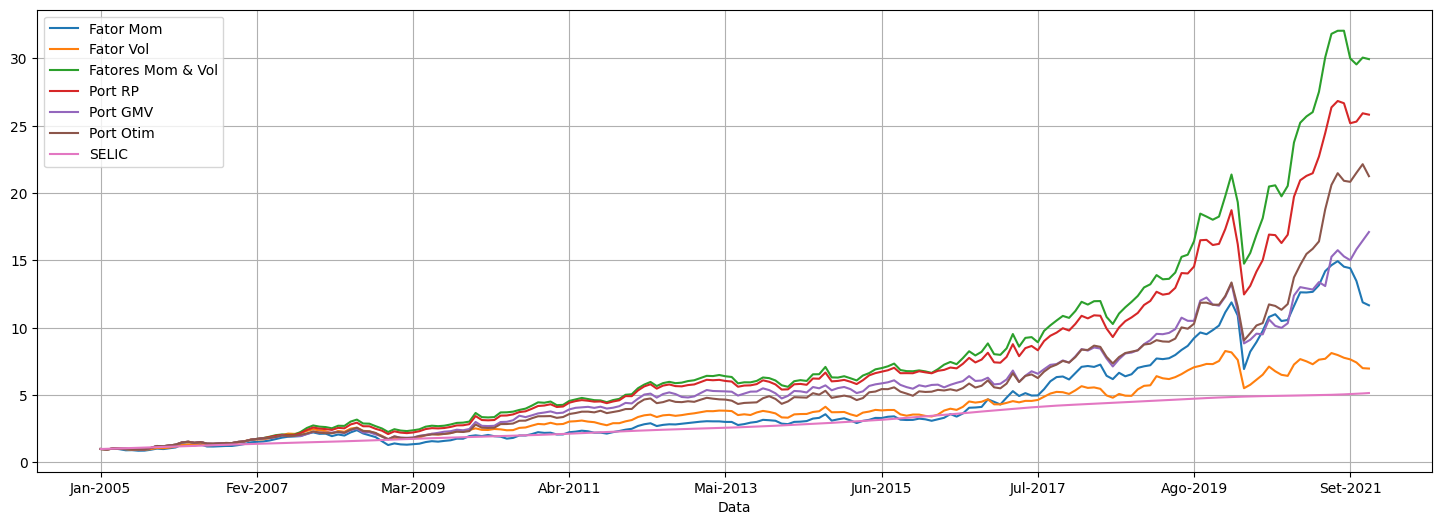

In [21]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
# Definindo o comprimento do índice de final_df
index_length = len(ranked_ROIC.iloc[data_inicial:data_final+1].index)

# Ajustando os vetores para ter o mesmo comprimento do índice
port_acc_vet1 = port_acc_vet1[:index_length]
port_acc_vet2 = port_acc_vet2[:index_length]
port_acc_vet3 = port_acc_vet3[:index_length]
port_acc_vet4 = port_acc_vet4[:index_length]
port_acc_vet5 = port_acc_vet5[:index_length]
port_acc_vet6 = port_acc_vet6[:index_length]
ref_acc_vet = ref_acc_vet[:index_length]

final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Fator Mom'] = port_acc_vet1
final_df['Fator Vol'] = port_acc_vet2
final_df['Fatores Mom & Vol'] = port_acc_vet3
final_df['Port RP'] = port_acc_vet4
final_df['Port GMV'] = port_acc_vet5
final_df['Port Otim'] = port_acc_vet6
final_df['SELIC'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

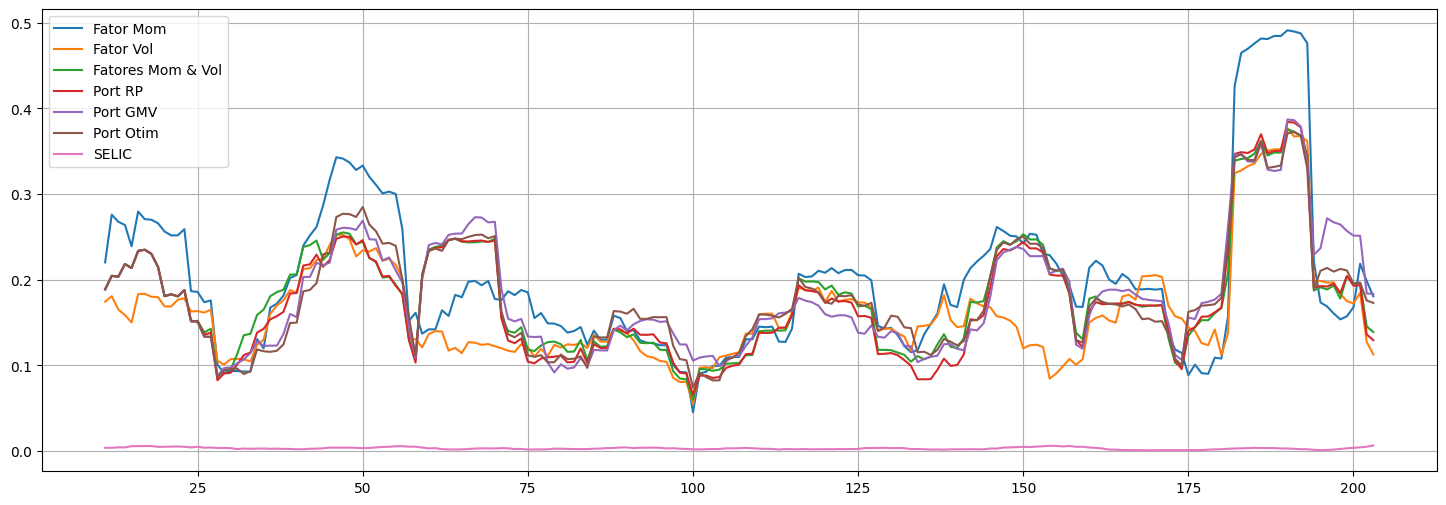

In [22]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Fator Mom'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Fator Vol'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Fatores Mom & Vol'] = pd.Series(port_chg_vet3).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port RP'] = pd.Series(port_chg_vet4).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port GMV'] = pd.Series(port_chg_vet5).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port Otim'] = pd.Series(port_chg_vet6).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['SELIC']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

<Axes: xlabel='Data'>

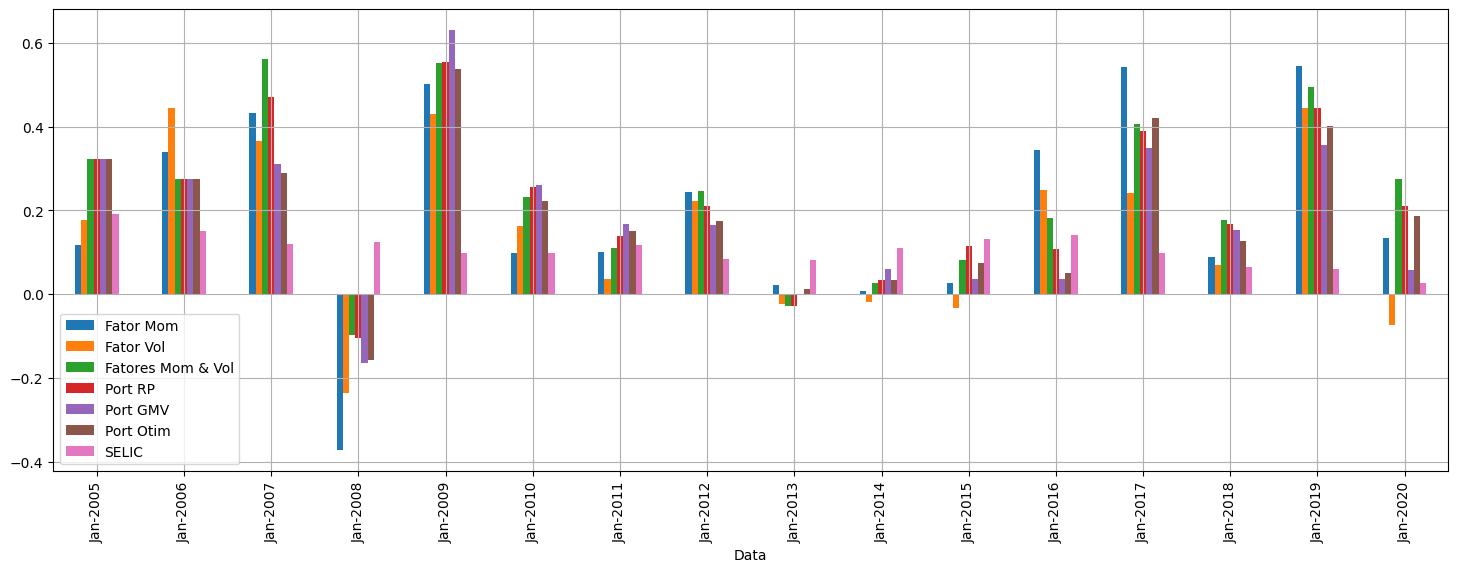

In [23]:
#Retorno anual de um portfólio e de uma referência (IBX)
final_df12 = pd.DataFrame(columns=['Data', 'Fator Mom', 'Fator Vol', 'Fatores Mom & Vol', 'Port RP', 'Port GMV', 'Port Otim', 'SELIC'])

for ind in range(0, len(final_df.index) - 12, 12):
    final_temp = final_df.iloc[ind + 12] / final_df.iloc[ind] - 1
    final_temp = final_temp.to_frame().T  # Transpor para garantir que é um DataFrame de uma linha
    final_temp['Data'] = final_df.index[ind]  # Adicionar a coluna de Data
    final_df12 = pd.concat([final_df12, final_temp], ignore_index=True)

# Configurar a coluna 'Data' como índice
final_df12.set_index(keys='Data', inplace=True)

# Plotar os dados
final_df12.plot.bar(figsize=(18, 6), grid=True)